# Tutorial 

## Introduction

`tutorial1.imzML` is a paint cross-section from paint model prepared at the Pratt Institute in 2008.The paint model is composed of 3 layer (ochre/linseed oil, lead white/casein, and gesso/collagen). The image was aquired on Orbitrap Q-Exactive with 5um spatial resolution. The dataset was peak picked and aligned using [Esmraldi](https://github.com/fgrelard/Esmraldi) tool-suite and library.

In this tutorial, we want to obtain **the prediction** on an Mass Spectrometry Imaging paint layer image (`tutorial1_aligned.imzML`). The model has been already been trained using Lasso on several annotated MSI datasets, including `tutorial1_aligned.imzML`. The model coefficients and parameters are stored in the file `model_lasso.joblib`. A Gaussian Mixture Model has been fit onto the Lasso coefficients to get the "Uncertain" class, for both binder and pigment predictions (`model_lasso_gmm_binders.joblib` and `model_lasso_gmm_pigments.joblib`).

## Prediction

The code below is contained in the `pls_test.py` and `evaluation_prediction_confusion.py` scripts. 

First, we import the necessary *Esmraldi* modules and define some utility functions.

In [64]:
import joblib
import glob
import pandas as pd
import argparse
import numpy as np
import os
import SimpleITK as sitk
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
import esmraldi.imzmlio as io
import esmraldi.utils as utils
import esmraldi.imageutils as imageutils
import esmraldi.fusion as fusion
import esmraldi.spectraprocessing as sp
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from skimage.filters import threshold_multiotsu
from skimage.morphology import opening, closing, erosion, dilation
from scipy.ndimage import binary_fill_holes
from sklearn.metrics import confusion_matrix

def normalize_flatten(spectra, coordinates, shape, normalization_tic=True, normalization_minmax=True):
    if normalization:
        print("Normalization TIC")
        spectra = sp.normalization_tic(spectra, inplace=True)
    full_spectra = io.get_full_spectra_dense(spectra, coordinates, shape)
    images = io.get_images_from_spectra(full_spectra, shape)
    if normalization_minmax:
        images = io.normalize(images)
    images = images.astype(np.float128) / 255.0
    image_flatten = fusion.flatten(images, is_spectral=True).T
    return image_flatten

def read_imzml(input_name, normalization):
    if input_name.lower().endswith(".imzml"):
        imzml = io.open_imzml(input_name)
        spectra = io.get_spectra(imzml)
        coordinates = imzml.coordinates
        max_x = max(coordinates, key=lambda item:item[0])[0]
        max_y = max(coordinates, key=lambda item:item[1])[1]
        max_z = max(coordinates, key=lambda item:item[2])[2]
        shape = (max_x, max_y, max_z)
        mzs = np.unique(np.hstack(spectra[:, 0]))
        mzs = mzs[mzs>0]
    return spectra, mzs, shape, imzml.coordinates

def indices_peaks(peaks, other_peaks):
    indices = utils.indices_search_sorted(other_peaks, peaks)
    current_step = 14 * other_peaks / 1e6
    indices_ppm = np.abs(peaks[indices] - other_peaks) < current_step
    indices[~indices_ppm] = -1
    return indices

def extract_parent_paths(imzml_name, shape, names):
    paths = []
    regions = np.zeros(shape[:-1] + (len(names),))
    parent_path = os.path.dirname(imzml_name)
    # mask_path = parent_path + os.path.sep + "masks/msi/*.tif"
    mask_path = parent_path + os.path.sep + "masks/resized/*.tif"
    files = glob.glob(mask_path)
    binders=[]
    pigments=[]
    for f in files:
        name = os.path.splitext(os.path.basename(f))[0]
        binder, pigment = name.split("_")
        image = sitk.GetArrayFromImage(sitk.ReadImage(f)).T
        ind_binder = np.where(names == binder)[0][0]
        binders.append(binder)
        ind_pigment = np.where(names == pigment)[0][0]
        pigments.append(pigment)
        regions[..., ind_binder] += image
        regions[..., ind_pigment] += image
    return regions, binders, pigments

def get_mask(index, masks, uncertain_label, hide_image):
    if index != uncertain_label+1:
        mask = masks[..., index]
    else:
        return np.zeros_like(masks[..., 0])
    mask = np.where(mask>0, 1, 0)
    mask -= hide_image
    mask = np.where(mask>0, 1, 0)
    return mask

def get_prediction(index, label_image, uncertain_label):
    cond = (label_image == index)
    pred = np.where(cond, 1, 0)
    return pred


Next, we input the path to the datasets and models.

In [50]:
#Path to the model trained previously
input_name = "tutorial/models/model_lasso.joblib"
#Actual MSI dataset (imzML)
target_name = "tutorial/tutorial1_aligned.imzML"

#Whether to normalize or not using TIC normalization
normalization = True

#Binders or pigments
analysis_names = ["Casein", "Collagen", "ET", "LO", "Matrix"]

#GMM model (optional)
gmm_name = "tutorial/models/model_lasso_gmm_binders.joblib"

#Confidence probability threshold to determine the uncertain class
proba = 0.95

And run the prediction.

Running...


Normalization TIC


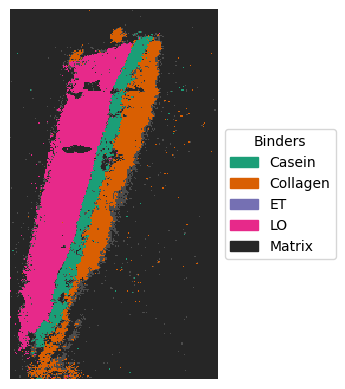

Done


In [51]:
print("Running...")
mzs_name = os.path.splitext(input_name)[0] + "_mzs.csv"
names_name = os.path.splitext(input_name)[0] + "_names.csv"
peaks = np.loadtxt(mzs_name)
names = np.loadtxt(names_name, dtype=str)


cm = plt.get_cmap("Dark2")
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(analysis_names))
spectra, mzs, shape, coords = read_imzml(target_name, normalization)


indices = indices_peaks(mzs, peaks)

target_im = normalize_flatten(spectra, coords, shape, normalization_tic=normalization, normalization_minmax=True)
blank_image = np.zeros((target_im.shape[0], 1))
target_im = np.hstack((target_im, blank_image))
target_im = target_im[..., indices]

# Load data from file
regression = joblib.load(input_name)
coef = regression.coef_
if coef.shape[0] < coef.shape[1]:
    coef = coef.T


data = np.column_stack((peaks, coef))
peaks_coef_name = os.path.dirname(outname) + os.path.sep + "coef.csv"
np.savetxt(peaks_coef_name, data, header="mzs,"+",".join(names), delimiter=",", comments="")

out = regression.predict(target_im)


if analysis_names is not None:
    inside = np.in1d(names, analysis_names)
    names = names[inside]
    out = out[..., inside]

if "ET&LO" in names:
    order = np.array([0, 1, 3, 4, 2])
    names = names[order]
    out = out[..., order]


labels = np.argmax(out, axis=-1)

array_colors = np.array(cm.colors)
names_array = np.array(analysis_names)
ind_mat = np.where((names_array == "Matrix") | (names_array == "Tape"))[0]
black = np.array([0.15, 0.15, 0.15])
array_colors[ind_mat, :] = black
cm = colors.ListedColormap(array_colors)

if gmm_name is not None:
    gmm = joblib.load(gmm_name)
    labels = gmm.predict(out)
    probas = gmm.predict_proba(out)
    labels = np.argsort(probas, axis=-1)[..., -1]
    uncertain_label = len(analysis_names)
    if proba > 0:
        labels[probas.max(axis=-1) < proba] = uncertain_label
    label_image = np.reshape(labels, shape[:-1]).T
    array_colors = np.array(cm.colors)
    gray = np.array([0.3, 0.3, 0.3])
    array_colors[uncertain_label, :] = gray
    cm = colors.ListedColormap(array_colors)
    plt.imshow(label_image, cmap=cm, vmin=0, vmax=cm.N, interpolation="nearest")

    names = np.append(names, ["Uncertain"])
else:
    min_value, max_value = np.amin(out, axis=0), np.amax(out, axis=0)
    min_value, max_value = np.amin(out), np.amax(out)
    opacity = (out - min_value) / (max_value - min_value)
    opacity = np.take_along_axis(opacity, labels[:, None], axis=-1)

    opacity_image = np.reshape(opacity, shape[:-1]).T.astype(np.float64)
    label_image = np.reshape(labels, shape[:-1]).T

    blacks = np.zeros_like(label_image)
    plt.imshow(blacks, cmap="gray")
    plt.imshow(label_image, cmap=cm, vmin=0, vmax=cm.N, alpha=opacity_image,  interpolation="nearest")

handles = [plt.Rectangle((0, 0), 0, 0, color=cm(int(i)), label=name) for i, name in enumerate(analysis_names)]

plt.legend(handles=handles, title="Binders", loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis("off")
plt.show()
print("Done")